In [166]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import expit  


np.random.seed(42)

# Load Pre-Processed CSVs
loans_df = pd.read_csv("../processed/loans.csv", delimiter=",")
customers_df = pd.read_csv("../processed/customer.csv", delimiter=",")
transactions_df = pd.read_csv("../processed/transactions.csv", delimiter=",")

# Feature Engineering (DTI, Avg Transaction Amount, and Transaction Frequency)
# Compute Debt-to-Income Ratio (DTI)
customers_df['dti'] = customers_df['debt'] / customers_df['income']

# Compute Transaction Frequency per Customer
transaction_frequency = transactions_df.groupby('customer_id')['transaction_id'].count().reset_index()
transaction_frequency.rename(columns={'transaction_id': 'transaction_frequency'}, inplace=True)

# Merge engineered features into Customers table
customers_df = customers_df.merge(transaction_frequency, on='customer_id', how='left')

# Fill missing values (for customers with no transactions)
customers_df['transaction_frequency'] = customers_df['transaction_frequency'].fillna(0)

customers_df

,customer_id,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value,dti,transaction_frequency
0,217,33,unemployed,single,primary,1,-23869.04,15283.08,277.46,26,10,1,243.87,55.082102,1.0
1,179,32,retired,single,secondary,1,-16434.66,12630.49,716.15,24,9,3,259.91,17.636654,1.0
2,81,20,unemployed,single,secondary,1,-11910.44,21609.58,539.38,10,8,3,224.93,40.063740,1.0
3,50,35,unemployed,single,tertiary,1,-10332.25,47532.55,269.77,27,0,3,355.19,176.196575,0.0
4,13,35,student,single,secondary,1,-8003.47,36324.75,522.33,27,9,1,299.71,69.543679,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3281,37,unknown,married,secondary,0,98279.81,36289.47,27848.66,34,2,2,961.25,1.303096,0.0
3996,3101,43,unknown,married,secondary,0,129681.74,10337.89,28432.42,40,0,2,767.80,0.363595,6.0
3997,3349,61,unknown,married,tertiary,0,164303.59,8223.83,29211.87,36,4,3,1002.67,0.281524,0.0
3998,2157,48,unknown,married,unknown,0,169448.44,10391.25,31063.57,41,8,1,1246.32,0.334516,0.0


In [167]:

# Generate Product Ownership based on Conditional Probabilities
df = pd.DataFrame({"customer_id": customers_df['customer_id']})

def scale_to_0_1(prob):
    return (prob - prob.min()) / (prob.max() - prob.min())

# Investment Product: High income, high balance, low DTI OR high CLV
investment_prob = (
    expit(customers_df['income'] / (customers_df['income'].median() *1.5)) * 0.4 +  
    (customers_df['balance'] / (customers_df['balance'].median() *1.5)) * 0.4 +  
    norm.cdf(customers_df['age'], 40, 15) * 0.4 +
    (1 - customers_df['dti']) * 0.5 +  
    (customers_df['customer_lifetime_value'] / customers_df['customer_lifetime_value'].median()) * 0.5  
)
df['has_investment_product'] = np.random.binomial(1, scale_to_0_1(investment_prob))


# Credit Card: Age, marital status, employment status
credit_card_prob = (
    norm.cdf(customers_df['age'], 35, 10) * 0.6 +  # Age distribution, assuming the average age for credit card owners is 30
    (customers_df['marital'] != 'Single') * 0.4 +  # Customers who are not single are more likely to have a credit card
    ((customers_df['job'] != 'Unemployed') & (customers_df['job'] != 'Student')) * 0.5  # Customers who are not unemployed or students
)
df['has_credit_card'] = np.random.binomial(1, scale_to_0_1(credit_card_prob))
# Ensure that if loan_purpose is 'credit card', has_credit_card is forced to 1
df.loc[loans_df['loan_purpose'] == 'credit_card', 'has_credit_card'] = 1

# Personal Loan
# Identify customers with UNPAID personal loans
personal_purposes = ["debt_consolidation", "major_purchase", "credit_card", "educational", "vacation", "wedding", "medical"]
unpaid_personal_loans = loans_df[
    loans_df['loan_purpose'].isin(personal_purposes) & loans_df['paid_off_date'].isnull()
]
df['has_personal_loan'] = df['customer_id'].isin(unpaid_personal_loans['customer_id']).astype(int)


# Fixed Deposit: High balance, long tenure, older age, and low dti
fixed_deposit_prob = (
    (customers_df['balance'] / customers_df['balance'].median()) * 0.3 +
    (customers_df['tenure'] / 240) * 0.3 +
    (customers_df['age'] / 70) * 0.3+
    (1 - customers_df['dti']) * 0.6
)
df['has_fixed_deposit'] = np.random.binomial(1, scale_to_0_1(fixed_deposit_prob))

# Insurance: Age, dependents, or moderate income
insurance_prob = (
    norm.cdf(customers_df['age'], 50, 15) * 0.3 +  
    norm.cdf(customers_df['income'], 12000, 6000) * 0.2 +  
    (customers_df['dependents'] / 3) * 0.7  
)
df['has_insurance'] = np.random.binomial(1, scale_to_0_1(insurance_prob))

# Print New Ownership Rates
print("Product Ownership Rates After Adjustments:\n", df.mean())

df

Product Ownership Rates After Adjustments:
 customer_id               2000.50000
has_investment_product       0.50975
has_credit_card              0.66925
has_personal_loan            0.27550
has_fixed_deposit            0.53775
has_insurance                0.43875
dtype: float64


,customer_id,has_investment_product,has_credit_card,has_personal_loan,has_fixed_deposit,has_insurance
0,217,0,0,1,1,0
1,179,1,1,1,1,0
2,81,1,0,1,0,0
3,50,0,0,0,1,0
4,13,0,0,1,0,0
...,...,...,...,...,...,...
3995,3281,1,1,1,1,0
3996,3101,1,1,1,0,0
3997,3349,1,1,1,1,1
3998,2157,1,0,0,0,1


In [168]:
# export to data folder
df.to_csv("../processed/products_owned.csv", index=False)

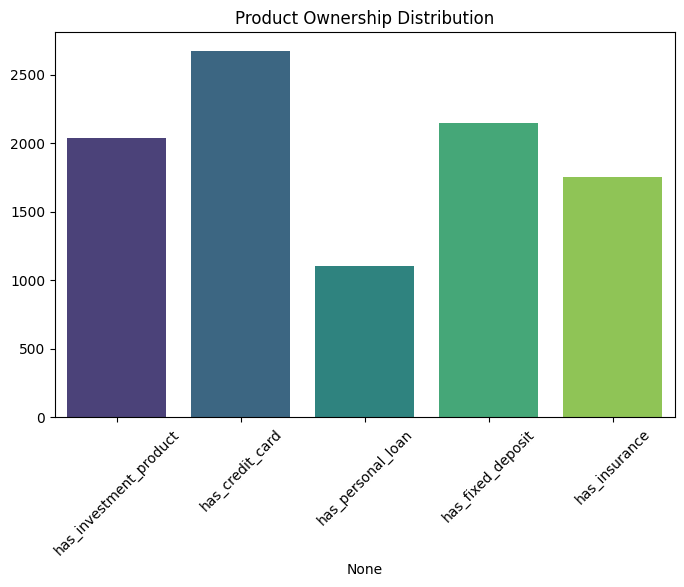

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of customers who own each product
ownership_counts = df.drop(columns=['customer_id']).sum()

plt.figure(figsize=(8, 5))
sns.barplot(x=ownership_counts.index, hue=ownership_counts.index, y=ownership_counts.values, palette='viridis')
plt.title('Product Ownership Distribution')
plt.xticks(rotation=45)
plt.show()
